# ShearNet Model Comparison Notebook  
This notebook compares multiple ShearNet models by loading their saved architectures and evaluating them on the same test dataset.  

**Features:**  
- Loads models from saved `architecture.py` files for comparison of model iterations
- Generates comprehensive comparison plots
- Uses centralized output management system

**Requirements:**  
- `plots/[model_name]/architecture.py` should contain the model class (done automatically)
- Model checkpoints should be in: `model_checkpoint/[model_name]/` (done automatically)
- Loss files should be in: `plots/[model_name]/[model_name]_loss.npz` (done automatically)

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import jax.random as random
import jax.numpy as jnp
import numpy as np
import optax
import os
from dataclasses import dataclass
from typing import List, Optional, Dict, Any, Tuple
import sys
import importlib.util
import re

from shearnet.core.dataset import generate_dataset, split_combined_images
from shearnet.config.config_handler import Config

from flax.training import checkpoints, train_state
from shearnet.utils.metrics import eval_model, eval_ngmix, eval_mcal, remove_nan_preds_multi

from shearnet.utils.plot_helpers import (
    plot_residuals, 
    plot_true_vs_predicted, 
    animate_model_epochs
)

from shearnet.utils.notebook_output_system import (
    log_print, save_plot, log_array_stats, experiment_section, get_output_manager
)

In [2]:
@dataclass
class ModelConfig:
    """Configuration for a ShearNet model to compare"""
    name: str  # Display name for plots
    model_dir_prefix: str  # Directory prefix to search for
    color: str  # Color for plots
    marker: str = 'o'  # Marker style for scatter plots
    
    def __post_init__(self):
        """Initialize configuration containers"""
        self.training_config = None
        self.test_config = None

@dataclass 
class NgmixConfig:
    """Configuration for NGmix comparison - allows full control over test dataset generation"""
    # Display properties
    name: str  # Display name for plots
    color: str  # Color for plots
    marker: str = '^'  # Marker style for scatter plots
    
    # Dataset generation parameters - you can control EVERYTHING here
    samples: int = 5000                    # Number of test galaxies
    psf_sigma: float = 0.25               # PSF size (sigma for Gaussian PSF)
    nse_sd: float = 1e-2                  # Noise standard deviation (controls noise level)
    exp: str = 'superbit'                    # Experiment type: 'ideal' or 'superbit'
    galaxy_type: str = 'gauss'            # Galaxy type: 'gauss' or 'exp' (exponential)
    seed: int = 42                        # Random seed for reproducibility
    stamp_size: int = 53                  # Image stamp size (npix x npix)
    pixel_size: float = 0.141             # Pixel scale in arcsec/pixel
    
    # PSF shear parameters - critical for testing shear calibration
    apply_psf_shear: bool = False         # Whether to apply random shear to PSF
    psf_shear_range: float = 0.05         # Maximum absolute PSF shear value (if apply_psf_shear=True)
    
    # Galaxy shape parameters
    flux_min: float = 1.0                 # Minimum galaxy flux
    flux_max: float = 5.0                 # Maximum galaxy flux  
    sigma_min: float = 0.5                # Minimum galaxy size (for size distribution)
    sigma_max: float = 1.5                # Maximum galaxy size
    
    # NGmix-specific fitting parameters
    psf_model: str = 'gauss'              # PSF model: 'gauss', 'em3', 'em2', 'coellip3', etc.
    gal_model: str = 'gauss'              # Galaxy model: 'gauss', 'exp', 'dev', 'bdf', etc.

def load_model_training_config(model_config: ModelConfig, base_data_path: str) -> Config:
    """Load the training configuration for a model"""
    config_path = os.path.join(base_data_path, "plots", model_config.model_dir_prefix, 'training_config.yaml')
    
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"No training config found at {config_path}")
    
    log_print(f"Loading training config for {model_config.name}: {config_path}")
    config = Config(config_path)
    model_config.training_config = config
    
    # Extract test configuration parameters
    model_config.test_config = {
        'samples': config.get('evaluation.test_samples', 5000),
        'psf_sigma': config.get('dataset.psf_sigma'),
        'nse_sd': config.get('dataset.nse_sd'),
        'exp': config.get('dataset.exp'),
        'seed': config.get('evaluation.seed', config.get('dataset.seed')),
        'stamp_size': config.get('dataset.stamp_size'),
        'pixel_size': config.get('dataset.pixel_size'),
        'apply_psf_shear': config.get('dataset.apply_psf_shear', False),
        'psf_shear_range': config.get('dataset.psf_shear_range', 0.05),
        'process_psf': config.get('model.process_psf', False),
        'nn_type': config.get('model.type'),
        'galaxy_type': config.get('model.galaxy.type'),
        'psf_type': config.get('model.psf.type')
    }
    
    return config

def generate_test_data_for_model(model_config: ModelConfig) -> Tuple[np.ndarray, np.ndarray, np.ndarray, List]:
    """Generate test data based on model's training configuration"""
    config = model_config.test_config
    
    log_print(f"Generating test data for {model_config.name}:")
    log_print(f"  Samples: {config['samples']}")
    log_print(f"  PSF sigma: {config['psf_sigma']}")
    log_print(f"  Noise SD: {config['nse_sd']}")
    log_print(f"  Experiment: {config['exp']}")
    log_print(f"  Stamp size: {config['stamp_size']}")
    log_print(f"  Pixel size: {config['pixel_size']}")
    log_print(f"  PSF shear: {config['apply_psf_shear']}")
    log_print(f"  Process PSF: {config['process_psf']}")
    
    # Generate test dataset
    combined_test_images, test_labels, test_obs = generate_dataset(
        config['samples'], config['psf_sigma'], npix=config['stamp_size'], 
        scale=config['pixel_size'], type='gauss', exp=config['exp'], 
        nse_sd=config['nse_sd'], seed=config['seed'], 
        process_psf=config['process_psf'], return_obs=True,
        apply_psf_shear=config['apply_psf_shear'], 
        psf_shear_range=config['psf_shear_range']
    )
    
    if config['process_psf']:
        # Split into separate galaxy and PSF arrays
        test_galaxy_images, test_psf_images = split_combined_images(combined_test_images)
        return test_galaxy_images, test_psf_images, test_labels, test_obs
    else:
        return combined_test_images, None, test_labels, test_obs

def load_model_from_architecture(model_config, base_checkpoint_path, base_data_path):
    """Load a model using its saved architecture.py file and evaluate it"""
    # Load training configuration first
    training_config = load_model_training_config(model_config, base_data_path)
    
    # Generate test data based on model's specific training configuration
    if model_config.test_config['process_psf']:
        test_galaxy_images, test_psf_images, test_labels, test_obs = generate_test_data_for_model(model_config)
    else:
        test_images, _, test_labels, test_obs = generate_test_data_for_model(model_config)
        test_galaxy_images = test_images
        test_psf_images = None
    
    # Path to the saved architecture file
    arch_file = os.path.join(base_data_path, "plots", model_config.model_dir_prefix, "architecture.py")

    if not os.path.exists(arch_file):
        raise FileNotFoundError(f"Architecture file not found: {arch_file}")

    log_print(f"Loading architecture from: {arch_file}")

    nn_type = model_config.test_config['nn_type']
    galaxy_type = model_config.test_config['galaxy_type']
    psf_type = model_config.test_config['psf_type']
    process_psf = model_config.test_config['process_psf']

    log_print(f"Model type: {nn_type}")
    if process_psf:
        log_print(f"Galaxy type: {galaxy_type}, PSF type: {psf_type}")
    
    # Dynamically import the architecture module
    spec = importlib.util.spec_from_file_location(f"{model_config.model_dir_prefix}_arch", arch_file)
    arch_module = importlib.util.module_from_spec(spec)
    sys.modules[f"{model_config.model_dir_prefix}_arch"] = arch_module
    spec.loader.exec_module(arch_module)

    # Get the appropriate model class from the loaded architecture
    if nn_type == "mlp":
        model = arch_module.SimpleGalaxyNN()
    elif nn_type == "cnn":
        model = arch_module.EnhancedGalaxyNN()
    elif nn_type == "resnet":
        model = arch_module.GalaxyResNet()
    elif nn_type == "research_backed":
        model = arch_module.ResearchBackedGalaxyResNet()
    elif nn_type == "forklens_psfnet":
        model = arch_module.ForkLensPSFNet()
    elif nn_type == "fork-like":
        model = arch_module.ForkLike(galaxy_model_type=galaxy_type, psf_model_type=psf_type)
    else:
        raise ValueError(f"Invalid model type specified: {nn_type}")

    log_print(f"Successfully loaded model: {type(model).__name__}")

    # Initialize model parameters
    rng_key = random.PRNGKey(model_config.test_config['seed'])
    if process_psf:
        init_params = model.init(rng_key, jnp.ones_like(test_galaxy_images[0]), jnp.ones_like(test_psf_images[0]))
    else:
        init_params = model.init(rng_key, jnp.ones_like(test_galaxy_images[0]))
    
    state = train_state.TrainState.create(
        apply_fn=model.apply, params=init_params, tx=optax.adam(1e-3)
    )
    
    prefix = re.escape(model_config.model_dir_prefix)
    pattern = f"^{prefix}(?:[0-9]|$)"

    # Get all directories first
    all_dirs = [
        d for d in os.listdir(base_checkpoint_path) 
        if os.path.isdir(os.path.join(base_checkpoint_path, d))
    ]

    # Apply precise matching
    matching_dirs = [
        d for d in all_dirs
        if re.match(pattern, d)
    ]

    log_print(f"Found {len(matching_dirs)} matching directories for {model_config.name}: {matching_dirs}")
    
    if not matching_dirs:
        raise FileNotFoundError(f"No directory found for {model_config.name} with prefix: {model_config.model_dir_prefix}")
    
    # Use the latest directory if multiple found
    model_dir = os.path.join(base_checkpoint_path, sorted(matching_dirs)[-1])
    log_print(f"Loading {model_config.name} from: {model_dir}")
    
    # Restore checkpoint
    state = checkpoints.restore_checkpoint(ckpt_dir=model_dir, target=state)
    log_print("Model checkpoint loaded successfully.")
    
    # Evaluate on the model's appropriate test data
    if process_psf:
        results = eval_model_fork_like(state, test_galaxy_images, test_psf_images, test_labels)
    else:
        results = eval_model(state, test_galaxy_images, test_labels)
    
    return {
        'preds': results["all_preds"],
        'config': model_config,
        'results': results,
        'type': 'shearnet',
        'test_labels': test_labels,
        'test_config': model_config.test_config
    }, training_config

def eval_model_fork_like(state, galaxy_images, psf_images, labels, batch_size=32):
    """Evaluate fork-like models that take separate galaxy and PSF inputs"""
    import time
    
    start_time = time.time()
    total_loss = 0
    total_samples = 0
    total_bias = 0
    
    # Initialize per-label accumulators
    total_loss_per_label = {
        'g1': 0, 'g2': 0, 'g1g2_combined': 0, 'sigma': 0, 'flux': 0
    }
    total_bias_per_label = {
        'g1': 0, 'g2': 0, 'g1g2_combined': 0, 'sigma': 0, 'flux': 0
    }
    
    all_preds = []
    for i in range(0, len(galaxy_images), batch_size):
        batch_galaxy = galaxy_images[i:i + batch_size]
        batch_psf = psf_images[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        
        # Get predictions
        preds = state.apply_fn(state.params, batch_galaxy, batch_psf, deterministic=True)
        all_preds.append(preds)
        
        # Calculate loss
        loss = optax.l2_loss(preds, batch_labels).mean()
        batch_bias = (preds - batch_labels).mean()
        batch_size_actual = len(batch_galaxy)
        
        # Accumulate metrics
        total_loss += loss * batch_size_actual
        total_bias += batch_bias * batch_size_actual
        total_samples += batch_size_actual
        
        # Per-label metrics
        loss_per_label = {
            'g1': optax.l2_loss(preds[:, 0], batch_labels[:, 0]).mean(),
            'g2': optax.l2_loss(preds[:, 1], batch_labels[:, 1]).mean(),
            'g1g2_combined': optax.l2_loss(preds[:, :2], batch_labels[:, :2]).mean(),
            'sigma': optax.l2_loss(preds[:, 2], batch_labels[:, 2]).mean(),
            'flux': optax.l2_loss(preds[:, 3], batch_labels[:, 3]).mean()
        }
        
        bias_per_label = {
            'g1': (preds[:, 0] - batch_labels[:, 0]).mean(),
            'g2': (preds[:, 1] - batch_labels[:, 1]).mean(),
            'g1g2_combined': (preds[:, :2] - batch_labels[:, :2]).mean(),
            'sigma': (preds[:, 2] - batch_labels[:, 2]).mean(),
            'flux': (preds[:, 3] - batch_labels[:, 3]).mean()
        }
        
        for label in total_loss_per_label:
            total_loss_per_label[label] += loss_per_label[label] * batch_size_actual
            total_bias_per_label[label] += bias_per_label[label] * batch_size_actual

    # Calculate averages
    avg_loss = total_loss / total_samples
    avg_bias = total_bias / total_samples
    
    avg_loss_per_label = {
        label: total / total_samples 
        for label, total in total_loss_per_label.items()
    }
    avg_bias_per_label = {
        label: total / total_samples 
        for label, total in total_bias_per_label.items()
    }
    
    total_time = time.time() - start_time
    
    return {
        'loss': avg_loss,
        'bias': avg_bias,
        'loss_per_label': avg_loss_per_label,
        'bias_per_label': avg_bias_per_label,
        'all_preds': jnp.concatenate(all_preds) if all_preds else None,
        'time_taken': total_time
    }

def evaluate_ngmix_config(ngmix_config: NgmixConfig):
    """Evaluate NGmix with specific configuration"""
    log_print(f"Generating test data for {ngmix_config.name}:")
    log_print(f"  Samples: {ngmix_config.samples}")
    log_print(f"  PSF σ: {ngmix_config.psf_sigma}")
    log_print(f"  Noise SD: {ngmix_config.nse_sd:.1e}")
    log_print(f"  Experiment: {ngmix_config.exp}")
    log_print(f"  Galaxy type: {ngmix_config.galaxy_type}")
    log_print(f"  PSF shear: {ngmix_config.apply_psf_shear}")
    
    # Generate test data for evaluation
    test_images, test_labels, test_obs = generate_dataset(
        ngmix_config.samples, 
        ngmix_config.psf_sigma, 
        npix=ngmix_config.stamp_size, 
        scale=ngmix_config.pixel_size,
        type=ngmix_config.galaxy_type,
        exp=ngmix_config.exp, 
        nse_sd=ngmix_config.nse_sd, 
        seed=ngmix_config.seed, 
        process_psf=False, 
        return_obs=True,
        apply_psf_shear=ngmix_config.apply_psf_shear,
        psf_shear_range=ngmix_config.psf_shear_range
    )
    
    # Evaluate NGmix
    log_print(f"Evaluating {ngmix_config.name} with {ngmix_config.psf_model}/{ngmix_config.gal_model} models...")
    results = eval_ngmix(test_obs, test_labels, seed=ngmix_config.seed,
                        psf_model=ngmix_config.psf_model, 
                        gal_model=ngmix_config.gal_model)
    
    return {
        'preds': results["preds"],
        'config': ngmix_config,
        'results': results,
        'type': 'ngmix',
        'test_labels': test_labels,
        'test_config': {
            'samples': ngmix_config.samples,
            'psf_sigma': ngmix_config.psf_sigma,
            'nse_sd': ngmix_config.nse_sd,
            'exp': ngmix_config.exp,
            'galaxy_type': ngmix_config.galaxy_type,
            'apply_psf_shear': ngmix_config.apply_psf_shear,
            'psf_shear_range': ngmix_config.psf_shear_range,
            'psf_model': ngmix_config.psf_model,
            'gal_model': ngmix_config.gal_model
        }
    }

## Configuration  
Modify this section to set up your comparison:

In [3]:
# ==============================================================================
# CONFIGURATION: MODIFY THIS TO SET UP YOUR COMPARISON
# ==============================================================================

# Define the models you want to compare
model_configs = [
    ModelConfig(
        name="Fork-like on SuperBit",
        model_dir_prefix="fork-like_-3_noise_superbits",
        color="blue", 
        marker="s"
    ),
    ModelConfig(
        name="Fork-like on Ideal",
        model_dir_prefix="fork-like_-3_noise_ideals",
        color="green", 
        marker="s"
    ),
    # Add more models here...
]

# Define NGmix configurations you want to compare
# You can control EVERY aspect of the test data generation here
# Set to empty list [] if you don't want any NGmix comparisons
ngmix_configs = [
    # NgmixConfig(
    #     name="ngmix",
    #     color="green",
    #     marker="o",
    #     samples=5000,
    #     psf_sigma=0.25,
    #     nse_sd=1e-2,
    #     exp='superbit',
    #     galaxy_type='gauss',
    #     seed=42
    # ),
]

# To disable NGmix comparisons entirely, use:
# ngmix_configs = []

# Print configuration
log_print("="*60)
log_print("MODULAR BENCHMARK CONFIGURATION", level="HEADER")
log_print("="*60)
log_print(f"ShearNet models to compare: {[config.name for config in model_configs]}")
log_print(f"NGmix configs to compare: {[config.name for config in ngmix_configs] if ngmix_configs else 'NO NGMIX'}")
log_print(f"Total methods to evaluate: {len(model_configs) + len(ngmix_configs)}")
log_print("="*60)

DEBUG: Current working directory: /home/adfield/ShearNet/notebooks
DEBUG: Found 'notebooks' in current path
DEBUG: Attempting to create directory: /home/adfield/ShearNet/notebooks/out
DEBUG: Directory created/exists: /home/adfield/ShearNet/notebooks/out
DEBUG: Directory is writable: True
DEBUG: Created new output file: /home/adfield/ShearNet/notebooks/out/out.md
ShearNet Output Manager initialized:
  Output directory: /home/adfield/ShearNet/notebooks/out
  Output file: /home/adfield/ShearNet/notebooks/out/out.md
  Directory exists: True
  Can write to directory: True
MODULAR BENCHMARK CONFIGURATION
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
ShearNet models to compare: ['Fork-like on SuperBit', 'Fork-like on Ideal']
NGmix configs to compare: NO NGMIX
Total methods to evaluate: 2


## Test Dataset Generation

In [4]:
with experiment_section("Test Dataset Generation"):
    base_data_path = os.getenv('SHEARNET_DATA_PATH', os.path.abspath('.'))
    
    # Default test dataset parameters (for plotting consistency)
    test_samples = 5000
    test_seed = 42
    
    rng_key = random.PRNGKey(test_seed)

    # Generate shared test dataset with PSF processing enabled to get both galaxy and PSF images
    combined_test_images, test_labels, test_obs = generate_dataset(
        test_samples, 0.25, npix=53, scale=0.141, type='gauss', exp='ideal', 
        nse_sd=1e-5, seed=test_seed, process_psf=True, return_obs=True
    )
    
    # Split into separate galaxy and PSF arrays
    test_galaxy_images, test_psf_images = split_combined_images(combined_test_images)
    
    log_print(f"Generated {len(test_galaxy_images)} shared test samples for plotting")
    log_print(f"Galaxy image shape: {test_galaxy_images.shape}")
    log_print(f"PSF image shape: {test_psf_images.shape}")
    log_print(f"Labels shape: {test_labels.shape}")
    
    # Log some array statistics
    log_array_stats("test_galaxy_images", test_galaxy_images)
    log_array_stats("test_psf_images", test_psf_images)
    log_array_stats("test_labels", test_labels)

Test Dataset Generation
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md


100%|██████████| 5000/5000 [00:06<00:00, 809.77it/s]


Generated 5000 shared test samples for plotting
Galaxy image shape: (5000, 53, 53)
PSF image shape: (5000, 53, 53)
Labels shape: (5000, 4)
test_galaxy_images stats: shape=(5000, 53, 53), min=-0.000, max=0.178, mean=0.001, std=0.005
test_psf_images stats: shape=(5000, 53, 53), min=-0.000, max=0.049, mean=0.000, std=0.003
test_labels stats: shape=(5000, 4), min=-0.949, max=5.000, mean=0.876, std=1.398
---


## Learning Curves Comparison

Learning Curves Comparison
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
Fork-like on SuperBit training stats:
  Final training loss: 0.000909
  Final validation loss: 0.000806
  Best validation loss: 0.000364 at epoch 44
  Total epochs: 69
Fork-like on Ideal training stats:
  Final training loss: 0.000098
  Final validation loss: 0.000126
  Best validation loss: 0.000126 at epoch 289
  Total epochs: 300
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/learning_curves_comparison_20250908_003932.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/learning_curves_comparison_20250908_003932.png (size: 394387 bytes)
![learning_curves_comparison_20250908_003932.png](learning_curves_comparison_20250908_003932.png)


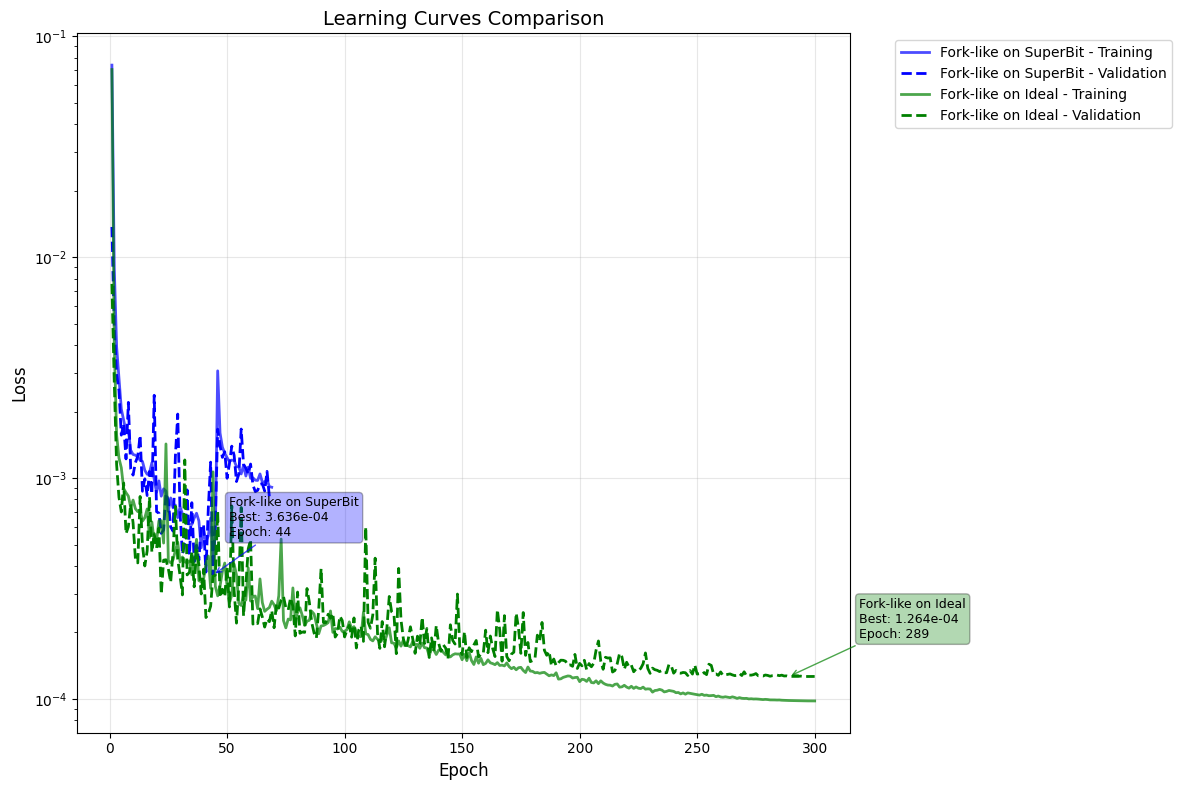

---


In [5]:
with experiment_section("Learning Curves Comparison"):
    base_data_path = os.getenv('SHEARNET_DATA_PATH', os.path.abspath('.'))
    
    plt.figure(figsize=(12, 8))
    
    for config in model_configs:
        # Load loss data for this model
        loss_file = os.path.join(base_data_path, "plots", config.model_dir_prefix, f"{config.model_dir_prefix}_loss.npz")
        
        if os.path.exists(loss_file):
            loss = np.load(loss_file)
            train_loss = loss['train_loss']
            val_loss = loss['val_loss']
            
            epochs = np.arange(1, len(train_loss) + 1)
            
            # Plot with model-specific colors
            plt.plot(epochs, train_loss, color=config.color, linestyle='-', 
                    label=f'{config.name} - Training', linewidth=2, alpha=0.7)
            plt.plot(epochs, val_loss, color=config.color, linestyle='--', 
                    label=f'{config.name} - Validation', linewidth=2)
            
            # Add annotations for best validation loss
            best_val_epoch = np.argmin(val_loss) + 1
            best_val_loss = np.min(val_loss)
            plt.annotate(f'{config.name}\nBest: {best_val_loss:.3e}\nEpoch: {best_val_epoch}',
                        xy=(best_val_epoch, best_val_loss), 
                        xytext=(best_val_epoch + len(epochs)*0.1, best_val_loss * 1.5),
                        arrowprops=dict(arrowstyle='->', color=config.color, alpha=0.7),
                        fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor=config.color, alpha=0.3))
            
            # Log statistics
            log_print(f"{config.name} training stats:")
            log_print(f"  Final training loss: {train_loss[-1]:.6f}")
            log_print(f"  Final validation loss: {val_loss[-1]:.6f}") 
            log_print(f"  Best validation loss: {best_val_loss:.6f} at epoch {best_val_epoch}")
            log_print(f"  Total epochs: {len(train_loss)}")
        else:
            log_print(f"Warning: Loss file not found for {config.name}: {loss_file}")

    plt.yscale("log")
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Learning Curves Comparison', fontsize=14)
    plt.legend(fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    save_plot("learning_curves_comparison.png")
    plt.show()

## Model Loading and Evaluation

In [6]:
with experiment_section("Model Loading and Evaluation"):
    base_checkpoint_path = os.path.join(base_data_path, "model_checkpoint")
    
    # Dictionary to store all results
    all_results = {}
    all_configs = {}
    
    # Evaluate each ShearNet model on its own training-based test configuration
    for model_config in model_configs:
        log_print(f"\nEvaluating {model_config.name}...", level="SUBHEADER")
        try:
            results, config = load_model_from_architecture(
                model_config, base_checkpoint_path, base_data_path
            )
            all_results[model_config.name] = results
            all_configs[model_config.name] = config
            log_print(f"Successfully evaluated {model_config.name}")
            log_print(f"  MSE: {results['results']['loss']:.3e}")
            log_print(f"  Bias: {results['results']['bias']:+.3e}")
        except Exception as e:
            log_print(f"Failed to evaluate {model_config.name}: {str(e)}")
            continue

    # Evaluate each NGmix configuration on its own specified test data
    if ngmix_configs:
        log_print(f"\nEvaluating {len(ngmix_configs)} NGmix configurations...", level="SUBHEADER")
        for ngmix_config in ngmix_configs:
            log_print(f"\nEvaluating {ngmix_config.name}...", level="SUBHEADER")
            try:
                results = evaluate_ngmix_config(ngmix_config)
                all_results[ngmix_config.name] = results
                log_print(f"Successfully evaluated {ngmix_config.name}")
                log_print(f"  MSE: {results['results']['loss']:.3e}")
                log_print(f"  Bias: {results['results']['bias']:+.3e}")
            except Exception as e:
                log_print(f"Failed to evaluate {ngmix_config.name}: {str(e)}")
                continue
    else:
        log_print("\nNo NGmix configurations to evaluate.", level="SUBHEADER")

    log_print(f"\nAll evaluations complete! Methods: {list(all_results.keys())}")

Model Loading and Evaluation
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md

Evaluating Fork-like on SuperBit...
Loading training config for Fork-like on SuperBit: /home/adfield/ShearNet/plots/fork-like_-3_noise_superbits/training_config.yaml
Generating test data for Fork-like on SuperBit:
  Samples: 5000
  PSF sigma: 0.25
  Noise SD: 0.001
  Experiment: superbit
  Stamp size: 53
  Pixel size: 0.141
  PSF shear: False
  Process PSF: True


100%|██████████| 5000/5000 [01:09<00:00, 71.94it/s]


Loading architecture from: /home/adfield/ShearNet/plots/fork-like_-3_noise_superbits/architecture.py
Model type: fork-like
Galaxy type: research_backed, PSF type: forklens_psf
Successfully loaded model: ForkLike
Found 1 matching directories for Fork-like on SuperBit: ['fork-like_-3_noise_superbits69']
Loading Fork-like on SuperBit from: /home/adfield/ShearNet/model_checkpoint/fork-like_-3_noise_superbits69
Model checkpoint loaded successfully.
Successfully evaluated Fork-like on SuperBit
  MSE: 8.863e-04
  Bias: -9.339e-04

Evaluating Fork-like on Ideal...
Loading training config for Fork-like on Ideal: /home/adfield/ShearNet/plots/fork-like_-3_noise_ideals/training_config.yaml
Generating test data for Fork-like on Ideal:
  Samples: 5000
  PSF sigma: 0.25
  Noise SD: 0.001
  Experiment: ideal
  Stamp size: 53
  Pixel size: 0.141
  PSF shear: False
  Process PSF: True


100%|██████████| 5000/5000 [00:06<00:00, 730.04it/s]


Loading architecture from: /home/adfield/ShearNet/plots/fork-like_-3_noise_ideals/architecture.py
Model type: fork-like
Galaxy type: research_backed, PSF type: forklens_psf
Successfully loaded model: ForkLike
Found 1 matching directories for Fork-like on Ideal: ['fork-like_-3_noise_ideals300']
Loading Fork-like on Ideal from: /home/adfield/ShearNet/model_checkpoint/fork-like_-3_noise_ideals300
Model checkpoint loaded successfully.
Successfully evaluated Fork-like on Ideal
  MSE: 1.319e-04
  Bias: -1.023e-04

No NGmix configurations to evaluate.

All evaluations complete! Methods: ['Fork-like on SuperBit', 'Fork-like on Ideal']
---


## Model Evaluation Summary

In [7]:
with experiment_section("Model Evaluation Summary"):
    if not all_results:
        log_print("No results available for evaluation summary.")
        log_print("Please check that your model configurations are correct and models can be loaded.")
    else:
        # Print summary statistics for all models
        log_print("="*60)
        log_print("EVALUATION SUMMARY", level="SUBHEADER")
        log_print("="*60)

        for model_name, result in all_results.items():
            log_print(f"\n{model_name} ({result['type'].upper()}):")
            
            # Print test configuration
            test_config = result['test_config']
            log_print(f"  Test Configuration:")
            log_print(f"    Samples: {test_config['samples']}")
            log_print(f"    PSF σ: {test_config['psf_sigma']}")
            log_print(f"    Noise SD: {test_config['nse_sd']:.1e}")
            log_print(f"    Experiment: {test_config['exp']}")
            log_print(f"    PSF Shear: {test_config.get('apply_psf_shear', False)}")
            
            if result['type'] == 'ngmix':
                log_print(f"    Galaxy Type: {test_config.get('galaxy_type', 'gauss')}")
                log_print(f"    PSF Model: {test_config.get('psf_model', 'gauss')}")
                log_print(f"    Galaxy Model: {test_config.get('gal_model', 'gauss')}")
            
            # Performance metrics
            eval_results = result['results']
            log_print(f"  Performance:")
            log_print(f"    Overall MSE: {eval_results['loss']:.3e}")
            log_print(f"    Overall Bias: {eval_results['bias']:+.3e}")
            log_print(f"    g1 MSE: {eval_results['loss_per_label']['g1']:.3e}")
            log_print(f"    g2 MSE: {eval_results['loss_per_label']['g2']:.3e}")
            if 'sigma' in eval_results['loss_per_label']:
                log_print(f"    σ MSE: {eval_results['loss_per_label']['sigma']:.3e}")
            if 'flux' in eval_results['loss_per_label']:
                log_print(f"    Flux MSE: {eval_results['loss_per_label']['flux']:.3e}")
            log_print(f"    Evaluation Time: {eval_results['time_taken']:.2f} seconds")

        log_print(f"\nReady for plotting with {len(all_results)} methods")

Model Evaluation Summary
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
EVALUATION SUMMARY

Fork-like on SuperBit (SHEARNET):
  Test Configuration:
    Samples: 5000
    PSF σ: 0.25
    Noise SD: 1.0e-03
    Experiment: superbit
    PSF Shear: False
  Performance:
    Overall MSE: 8.863e-04
    Overall Bias: -9.339e-04
    g1 MSE: 1.026e-03
    g2 MSE: 1.115e-03
    σ MSE: 4.071e-04
    Flux MSE: 9.967e-04
    Evaluation Time: 29.15 seconds

Fork-like on Ideal (SHEARNET):
  Test Configuration:
    Samples: 5000
    PSF σ: 0.25
    Noise SD: 1.0e-03
    Experiment: ideal
    PSF Shear: False
  Performance:
    Overall MSE: 1.319e-04
    Overall Bias: -1.023e-04
    g1 MSE: 5.680e-05
    g2 MSE: 5.508e-05
    σ MSE: 4.121e-05
    Flux MSE: 3.743e-04
    Evaluation Time: 12.42 seconds

Ready for plotting with 2 methods
---


## Prediction Comparison Plots

Prediction Comparison Plots
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/prediction_comparison_20250908_004149.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/prediction_comparison_20250908_004149.png (size: 1226704 bytes)
![prediction_comparison_20250908_004149.png](prediction_comparison_20250908_004149.png)


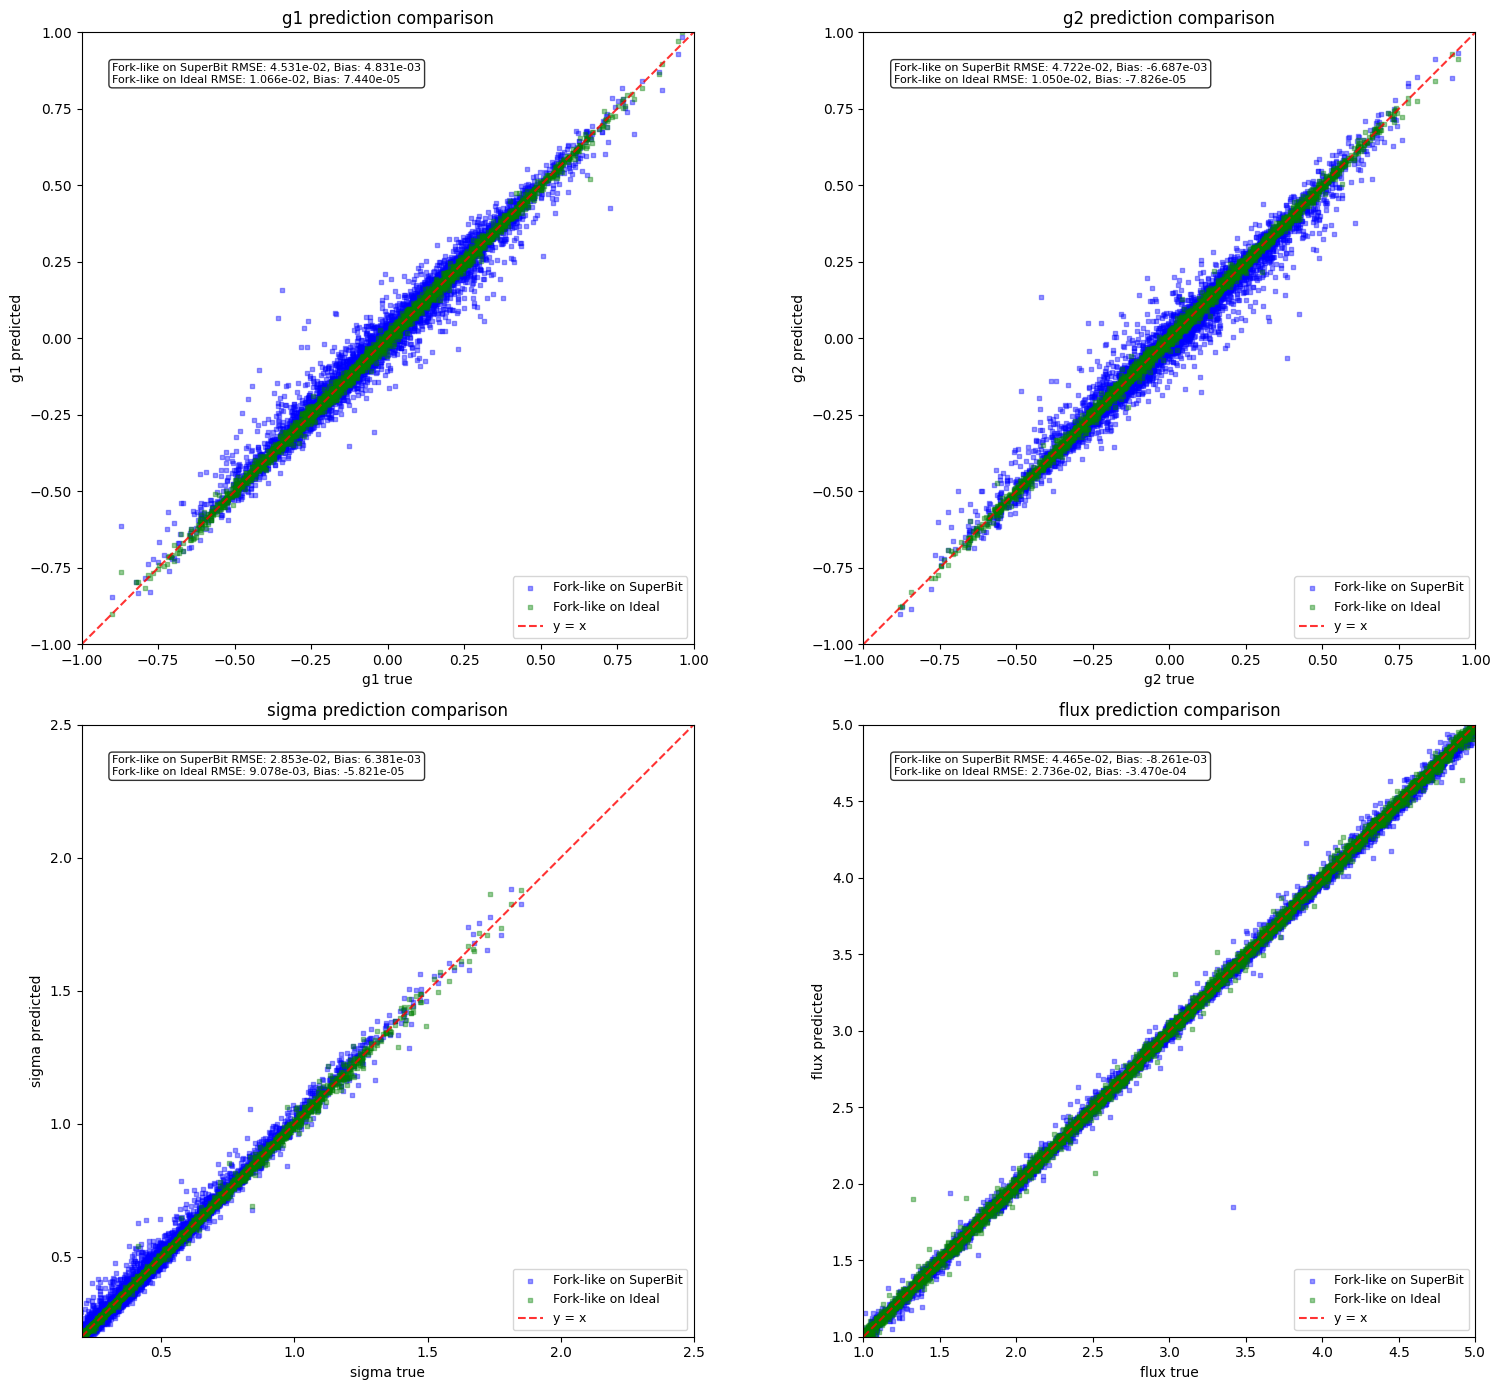

---


In [8]:
with experiment_section("Prediction Comparison Plots"):
    if not all_results:
        log_print("No results available for plotting.")
    else:
        # Set up plot
        fig, axs = plt.subplots(2, 2, figsize=(16, 14))
        quantities = [
            ("g1", -1., 1.),
            ("g2", -1., 1.),
            ("sigma", 0.2, 2.5),
            ("flux", 1, 5.)
        ]
        
        for ax, (name, vmin, vmax) in zip(axs.flat, quantities):
            param_idx = ["g1", "g2", "sigma", "flux"].index(name)
            
            # Plot each model's predictions
            for model_name, result in all_results.items():
                preds = result['preds'][:, param_idx]
                true_vals = result['test_labels'][:, param_idx]  # Each method has its own test labels
                
                if result['type'] == 'ngmix':
                    color = result['config'].color
                    marker = result['config'].marker
                    label = model_name
                else:
                    color = result['config'].color
                    marker = result['config'].marker
                    label = model_name
                
                ax.scatter(true_vals, preds, alpha=0.4, label=label, s=10, 
                          color=color, marker=marker)
            
            # Reference line
            ax.plot([vmin, vmax], [vmin, vmax], 'r--', label='y = x', alpha=0.8)
            
            # Axes formatting
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.set_aspect('equal', adjustable='box')
            ax.set_xlabel(f"{name} true")
            ax.set_ylabel(f"{name} predicted")
            ax.set_title(f"{name} prediction comparison")

            # Calculate and display metrics
            metrics_text = ""
            for model_name, result in all_results.items():
                preds = result['preds'][:, param_idx]
                true_vals = result['test_labels'][:, param_idx]
                rmse = np.sqrt(np.mean((preds - true_vals)**2))
                bias = np.mean(preds - true_vals)
                metrics_text += f"{model_name} RMSE: {rmse:.3e}, Bias: {bias:.3e}\n"

            ax.text(0.05, 0.95, metrics_text.strip(),
                    transform=ax.transAxes, fontsize=8,
                    verticalalignment='top',
                    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

            ax.legend(fontsize=9)

        plt.tight_layout()
        save_plot("prediction_comparison.png")
        plt.show()

## Residuals Comparison Plots

Residuals Comparison Plots
DEBUG: Logged to file: /home/adfield/ShearNet/notebooks/out/out.md
DEBUG: Attempting to save plot to: /home/adfield/ShearNet/notebooks/out/residuals_comparison_20250908_004157.png
SUCCESS: Plot saved to /home/adfield/ShearNet/notebooks/out/residuals_comparison_20250908_004157.png (size: 332537 bytes)
![residuals_comparison_20250908_004157.png](residuals_comparison_20250908_004157.png)


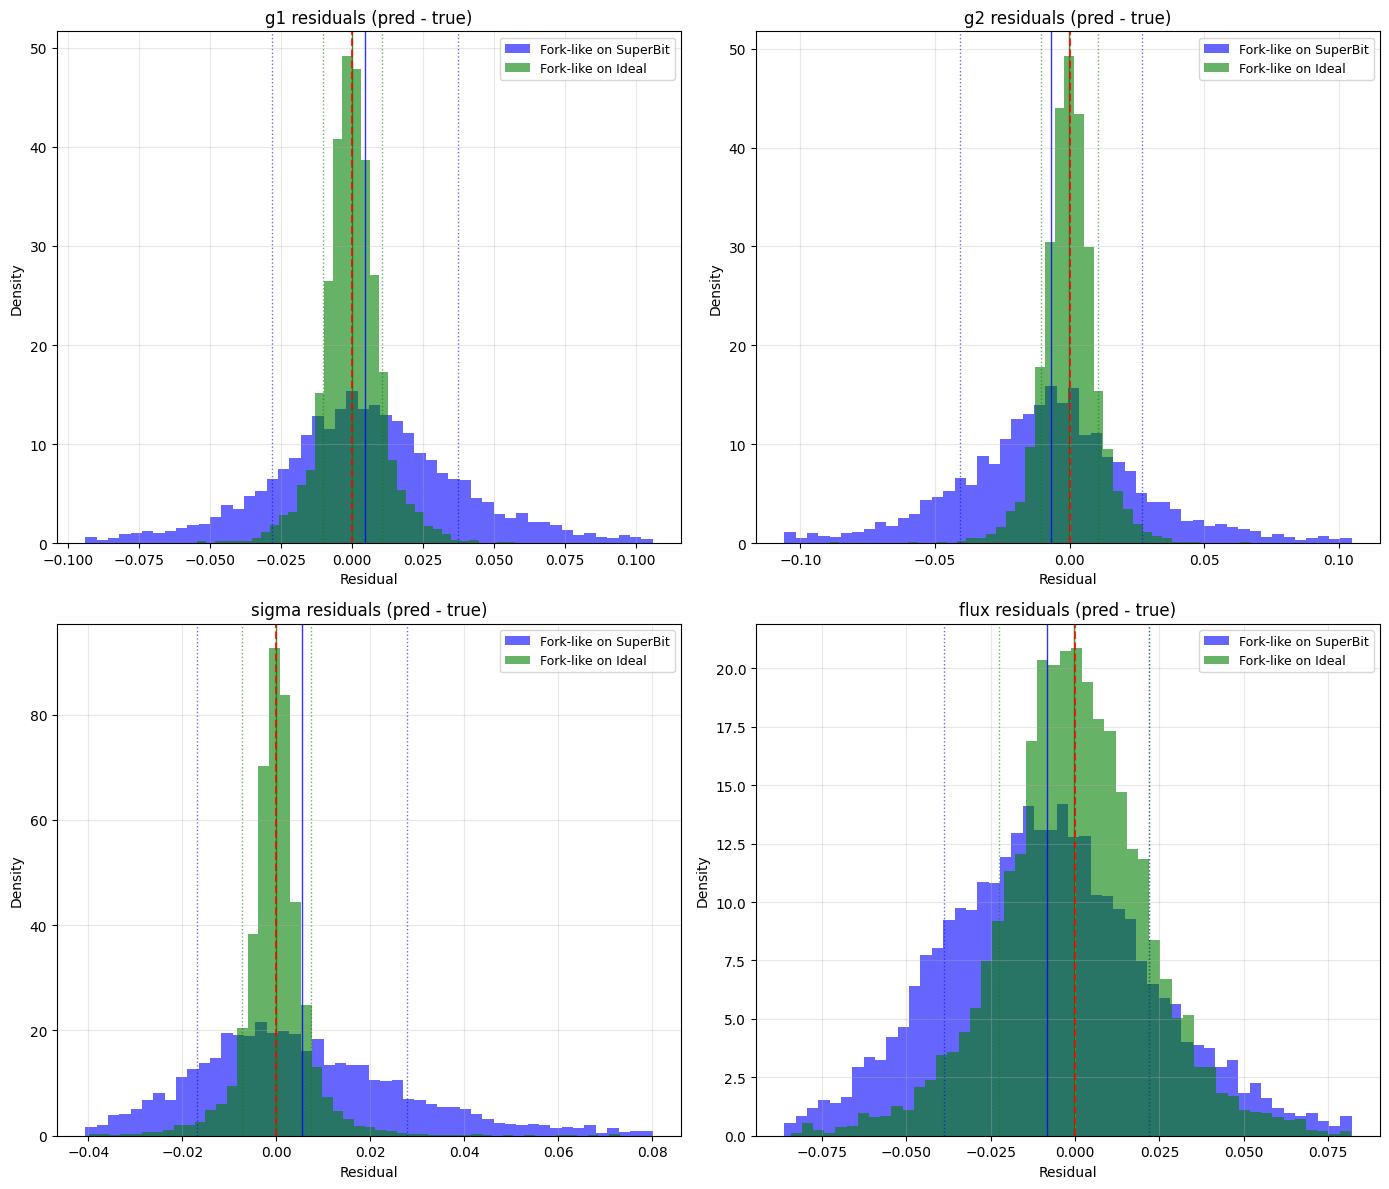

---


In [9]:
with experiment_section("Residuals Comparison Plots"):
    if not all_results:
        log_print("No results available for residuals plotting.")
    else:
        # Compute residuals for all models
        residuals_data = {}
        for model_name, result in all_results.items():
            preds = result['preds']
            test_labels = result['test_labels']  # Each method has its own test labels
            residuals_data[model_name] = {
                "g1": preds[:, 0] - test_labels[:, 0],
                "g2": preds[:, 1] - test_labels[:, 1], 
                "sigma": preds[:, 2] - test_labels[:, 2],
                "flux": preds[:, 3] - test_labels[:, 3],
                "result": result
            }

        fig, axs = plt.subplots(2, 2, figsize=(14, 12))
        bins = 50

        for ax, param in zip(axs.flat, ["g1", "g2", "sigma", "flux"]):
            # Collect all residuals for this parameter to determine clipping
            all_residuals = []
            for model_name, model_residuals in residuals_data.items():
                all_residuals.extend(model_residuals[param])
        
            if all_residuals:  # Only proceed if we have residuals
                # Clip extremes to focus on the bulk distribution
                clip_min = np.percentile(all_residuals, 1)
                clip_max = np.percentile(all_residuals, 99)

                # Plot histograms for each model
                for model_name, model_residuals in residuals_data.items():
                    residuals = model_residuals[param]
                    result = model_residuals["result"]
                    
                    # Clip residuals
                    residuals_clipped = residuals[(residuals >= clip_min) & (residuals <= clip_max)]
                    
                    if result['type'] == 'ngmix':
                        color = result['config'].color
                        label = model_name
                    else:
                        color = result['config'].color
                        label = model_name
                    
                    ax.hist(residuals_clipped, bins=bins, alpha=0.6, label=label, 
                           color=color, density=True)
                    
                    # Add mean ± std lines
                    mean = np.mean(residuals_clipped)
                    std = np.std(residuals_clipped)
                    ax.axvline(mean, color=color, linestyle='-', linewidth=1, alpha=0.8)
                    ax.axvline(mean + std, color=color, linestyle=':', linewidth=1, alpha=0.6)
                    ax.axvline(mean - std, color=color, linestyle=':', linewidth=1, alpha=0.6)
            
            ax.axvline(0, color='red', linestyle='--', alpha=0.8)
            
            # Labels
            ax.set_title(f"{param} residuals (pred - true)")
            ax.set_xlabel("Residual")
            ax.set_ylabel("Density")
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)

        plt.tight_layout()
        save_plot("residuals_comparison.png")
        plt.show()